In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

In [83]:
# OLD
etas = [0.1]
batches = [256]
epochs = [20]
rhos = np.linspace(0., 1, 5)
mus = np.linspace(0., 1, 5)

In [95]:
# new (fine-grained)
etas = [0.1]
batches = [256]
epochs = [20]
rhos = np.linspace(0.6, 0.8, 5)
mus = np.linspace(0.4, 0.6, 5)

In [96]:
rhos

array([0.6 , 0.65, 0.7 , 0.75, 0.8 ])

In [97]:
def get_file(**kwargs):
    return ("_".join([x + '-' + str(y) for x, y in kwargs.items()])+'.output')

In [98]:
def print_one(**kwargs):
    print('python experiment.py ' + " ".join(['--' + x + ' ' + str(y) for x, y in kwargs.items()]) + ' &')

In [99]:
print(get_file(aba = 'caba', dd = 'dd'))
print_one(aba = 'caba', dd = 'dd')

aba-caba_dd-dd.output
python experiment.py --aba caba --dd dd &


In [100]:
for eta in etas:
    for b in batches:
        for e in epochs:
            for rho in rhos:
                mu = 0
                print_one(eta = eta, rho = rho, mu = mu, epochs = e, train_batch_size = b)
            for mu in mus:
                rho = 0
                print_one(eta = eta, rho = rho, mu = mu, epochs = e, train_batch_size = b)

python experiment.py --eta 0.1 --rho 0.6 --mu 0 --epochs 20 --train_batch_size 256 &
python experiment.py --eta 0.1 --rho 0.65 --mu 0 --epochs 20 --train_batch_size 256 &
python experiment.py --eta 0.1 --rho 0.7 --mu 0 --epochs 20 --train_batch_size 256 &
python experiment.py --eta 0.1 --rho 0.75 --mu 0 --epochs 20 --train_batch_size 256 &
python experiment.py --eta 0.1 --rho 0.8 --mu 0 --epochs 20 --train_batch_size 256 &
python experiment.py --eta 0.1 --rho 0 --mu 0.4 --epochs 20 --train_batch_size 256 &
python experiment.py --eta 0.1 --rho 0 --mu 0.45 --epochs 20 --train_batch_size 256 &
python experiment.py --eta 0.1 --rho 0 --mu 0.5 --epochs 20 --train_batch_size 256 &
python experiment.py --eta 0.1 --rho 0 --mu 0.55 --epochs 20 --train_batch_size 256 &
python experiment.py --eta 0.1 --rho 0 --mu 0.6 --epochs 20 --train_batch_size 256 &


In [105]:
def process_dict(d, do_plot = False):
    if do_plot:
        plt.title('Train loss')
        plt.plot(d['train_batch_losses'])
        plt.show()
        plt.title('Train accuracy')
        plt.plot(d['train_batch_accs'])
        plt.show()
    del d['train_batch_losses'], d['train_batch_accs']
    return d

In [106]:
def process_file(f):
    f = open(f, 'r').read()
    d = eval(f)
    return process_dict(d)

In [107]:
def process_files(params, param_name, files):
    quantities = {}
    for f in files:
        d = process_file(f)
        for x, y in d.items():
            if x not in quantities:
                quantities[x] = []
            quantities[x].append(y)
            
    for x, y in quantities.items():
        print(x + ": min/max " + str(np.min(y)) + "/" + str(np.max(y)))
            
    plt.figure()
    plt.title('Accuracy over ' + param_name)
    plt.plot(params, quantities['test_accuracy'], label = 'Test accuracy')
    plt.plot(params, quantities['train_accuracy'], label = 'Test accuracy')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.title('Loss over ' + param_name)
    plt.plot(params, quantities['test_loss'], label = 'Test loss')
    plt.plot(params, quantities['train_loss'], label = 'Test loss')
    plt.legend()
    plt.show()

train_accuracy: min/max 83.1277704117146/91.85782360320395
train_loss: min/max 0.15703826039395433/0.2608455278771989
test_accuracy: min/max 83.25/91.98999786376953
test_loss: min/max 0.15055961906909943/0.25764647126197815


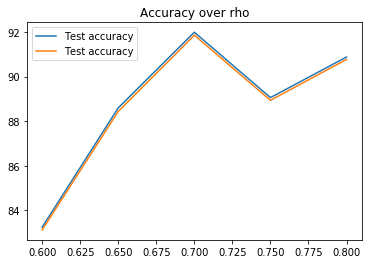

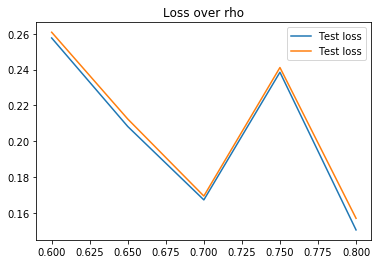

train_accuracy: min/max 88.1687721739424/93.56272164202751
train_loss: min/max 0.12830276295859763/0.20570064986005743
test_accuracy: min/max 88.15999603271484/93.68000030517578
test_loss: min/max 0.1314106434583664/0.20639313757419586


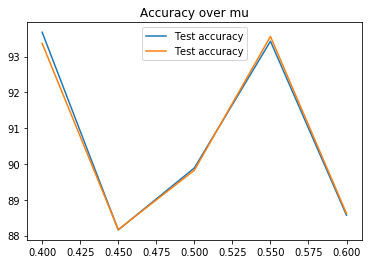

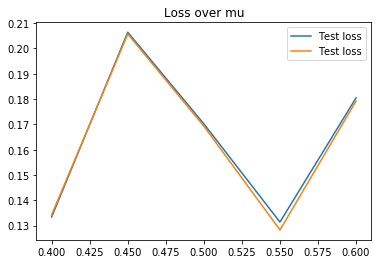

In [108]:
for eta in etas:
    for b in batches:
        for e in epochs:
            fs = [get_file(eta = eta, rho = rho, mu = 0.0, epochs = e,
                           train_batch_size = b) for rho in rhos]
            process_files(rhos, 'rho', fs)
                
                
            fs = [get_file(eta = eta, rho = 0.0, mu = mu, epochs = e,
                           train_batch_size = b) for mu in mus]
            process_files(mus, 'mu', fs)